# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

class MyBinaryLogisticRegression:
    def __init__(self,
                 regularization='l2',
                 lambda_=1.0,
                 optimizer='gradient_descent',
                 learning_rate=0.01,
                 num_iterations=1000,
                 tolerance=1e-6,
                 batch_size=32,
                 verbose=False):

        self.regularization = regularization
        self.lambda_ = lambda_
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.tolerance = tolerance
        self.batch_size = batch_size
        self.verbose = verbose
        self.coefs_ = None
        self.intercept_ = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))

    def _compute_loss(self, X, y):
        m = X.shape[0]
        h = self._sigmoid(X @ self.coefs_)
        epsilon = 1e-15
        loss = - (1/m) * (y.T @ np.log(h + epsilon) + (1 - y).T @ np.log(1 - h + epsilon))
        # Регуляризация
        if self.regularization == 'l2':
            loss += (self.lambda_ / (2 * m)) * np.sum(self.coefs_[1:] ** 2)
        elif self.regularization == 'l1':
            loss += (self.lambda_ / m) * np.sum(np.abs(self.coefs_[1:]))
        elif self.regularization == 'l1l2':
            loss += (self.lambda_ / (2 * m)) * np.sum(self.coefs_[1:] ** 2) + (self.lambda_ / m) * np.sum(np.abs(self.coefs_[1:]))
        return loss

    def _compute_gradient(self, X, y):
        m = X.shape[0]
        h = self._sigmoid(X @ self.coefs_)
        gradient = (1/m) * (X.T @ (h - y))
        # Регуляризация
        if self.regularization == 'l2':
            gradient[1:] += (self.lambda_ / m) * self.coefs_[1:]
        elif self.regularization == 'l1':
            gradient[1:] += (self.lambda_ / m) * np.sign(self.coefs_[1:])
        elif self.regularization == 'l1l2':
            gradient[1:] += (self.lambda_ / m) * self.coefs_[1:] + (self.lambda_ / m) * np.sign(self.coefs_[1:])
        return gradient

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = self._add_intercept(X.values)
        y = y.values
        n_features = X.shape[1]
        self.coefs_ = np.zeros(n_features)

        if self.optimizer == 'gradient_descent':
            self._fit_gradient_descent(X, y)
        elif self.optimizer == 'stochastic_gradient_descent':
            self._fit_sgd(X, y)
        elif self.optimizer == 'newton':
            self._fit_newton_method(X, y)
        else:
            raise ValueError("Unsupported optimizer type.")

    def _fit_gradient_descent(self, X, y):
        for i in range(self.num_iterations):
            gradient = self._compute_gradient(X, y)
            previous_coef = self.coefs_.copy()
            self.coefs_ -= self.learning_rate * gradient
            # Проверка сходимости
            if np.linalg.norm(self.coefs_ - previous_coef, ord=1) < self.tolerance:
                if self.verbose:
                    print(f"Gradient Descent converged at iteration {i}")
                break
            if self.verbose and i % 100 == 0:
                loss = self._compute_loss(X, y)
                print(f"Iteration {i}: Loss={loss}")

    def _fit_sgd(self, X, y):
        m = X.shape[0]
        for i in range(self.num_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for start in range(0, m, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                gradient = self._compute_gradient(X_batch, y_batch)
                self.coefs_ -= self.learning_rate * gradient
            # Проверка сходимости
            loss = self._compute_loss(X, y)
            if self.verbose and i % 100 == 0:
                print(f"Iteration {i}: Loss={loss}")
            if i > 0 and abs(previous_loss - loss) < self.tolerance:
                if self.verbose:
                    print(f"SGD converged at iteration {i}")
                break
            previous_loss = loss

    def _fit_newton_method(self, X, y):
        for i in range(self.num_iterations):
            h = self._sigmoid(X @ self.coefs_)
            gradient = self._compute_gradient(X, y)
            # Вычисление гессиана
            diag = h * (1 - h)
            H = (X.T * diag) @ X / X.shape[0]
            # Регуляризация гессиана
            if self.regularization == 'l2':
                H[1:,1:] += (self.lambda_ / X.shape[0]) * np.eye(X.shape[1]-1)
            elif self.regularization == 'l1':
                raise NotImplementedError("Newton's method is not suitable for L1 regularization.")
            elif self.regularization == 'l1l2':
                raise NotImplementedError("Newton's method is not implemented for L1L2 regularization.")
            try:
                delta = np.linalg.inv(H) @ gradient
            except np.linalg.LinAlgError:
                if self.verbose:
                    print("Hessian is singular. Stopping Newton's method.")
                break
            self.coefs_ -= delta
            # Проверка сходимости
            if np.linalg.norm(delta, ord=1) < self.tolerance:
                if self.verbose:
                    print(f"Newton's Method converged at iteration {i}")
                break
            if self.verbose and i % 10 == 0:
                loss = self._compute_loss(X, y)
                print(f"Iteration {i}: Loss={loss}")

    def predict_proba(self, X: pd.DataFrame):
        X = self._add_intercept(X.values)
        return self._sigmoid(X @ self.coefs_)

    def predict(self, X: pd.DataFrame):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def score(self, X: pd.DataFrame, y: pd.Series):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)


In [ ]:
import pandas as pd

file_path = "penguins.csv"
df = pd.read_csv(file_path)

df['target'] = (df['species'] == 'Adelie').astype(int)

def target_encode(train, test, target, column):
    mapping = train.groupby(column)[target].mean()
    train_encoded = train[column].map(mapping)
    test_encoded = test[column].map(mapping).fillna(mapping.mean())
    return train_encoded, test_encoded

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

train_te, test_te = target_encode(train_df, test_df, 'target', 'island')
train_df = train_df.copy()
test_df = test_df.copy()
train_df['island_te'] = train_te
test_df['island_te'] = test_te

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(train_df[['island']])
train_ohe = encoder.transform(train_df[['island']])
test_ohe = encoder.transform(test_df[['island']])
ohe_columns = encoder.get_feature_names_out(['island'])
train_df_ohe = train_df.copy()
test_df_ohe = test_df.copy()
train_df_ohe[ohe_columns] = train_ohe
test_df_ohe[ohe_columns] = test_ohe

features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year']
X_train_te = train_df[features + ['island_te']]
X_test_te = test_df[features + ['island_te']]
X_train_ohe = train_df_ohe[features + list(ohe_columns)]
X_test_ohe = test_df_ohe[features + list(ohe_columns)]

y_train = train_df['target']
y_test = test_df['target']

In [ ]:
from itertools import product

def train_and_evaluate(X_train, X_test, y_train, y_test, encoding_type):
    regularizations = ['none', 'l1', 'l2', 'l1l2']
    optimizers = ['gradient_descent', 'stochastic_gradient_descent', 'newton']
    results = []

    for reg, opt in product(regularizations, optimizers):
        if opt == 'newton' and reg in ['l1', 'l1l2']:
            continue
        if reg == 'none':
            reg_type = None
        else:
            reg_type = reg
        try:
            model = MyBinaryLogisticRegression(
                regularization=reg_type,
                lambda_=1.0,
                optimizer=opt,
                learning_rate=0.1,
                num_iterations=100,
                tolerance=1e-6,
                batch_size=32,
                verbose=False
            )
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            results.append({
                'Encoding': encoding_type,
                'Regularization': reg_type,
                'Optimizer': opt,
                'F1-Score': score
            })
            print(f"Encoding: {encoding_type}, Regularization: {reg_type}, Optimizer: {opt}, F1-Score: {score:.4f}")
        except NotImplementedError as e:
            print(f"Encoding: {encoding_type}, Regularization: {reg_type}, Optimizer: {opt} - {str(e)}")
        except Exception as e:
            print(f"Encoding: {encoding_type}, Regularization: {reg_type}, Optimizer: {opt} - Error: {str(e)}")
    return results

print("=== Target Encoding ===")
results_te = train_and_evaluate(X_train_te, X_test_te, y_train, y_test, 'Target Encoding')

print("\n=== One-Hot Encoding ===")
results_ohe = train_and_evaluate(X_train_ohe, X_test_ohe, y_train, y_test, 'One-Hot Encoding')

all_results = pd.DataFrame(results_te + results_ohe)
print("\n=== Результаты ===")
print(all_results)

=== Target Encoding ===
Encoding: Target Encoding, Regularization: None, Optimizer: gradient_descent, F1-Score: 0.8219
Encoding: Target Encoding, Regularization: None, Optimizer: stochastic_gradient_descent, F1-Score: 0.8889
Encoding: Target Encoding, Regularization: None, Optimizer: newton, F1-Score: 0.5753
Encoding: Target Encoding, Regularization: l1, Optimizer: gradient_descent, F1-Score: 0.8219
Encoding: Target Encoding, Regularization: l1, Optimizer: stochastic_gradient_descent, F1-Score: 0.9333
Encoding: Target Encoding, Regularization: l2, Optimizer: gradient_descent, F1-Score: 0.8219
Encoding: Target Encoding, Regularization: l2, Optimizer: stochastic_gradient_descent, F1-Score: 0.5366
Encoding: Target Encoding, Regularization: l2, Optimizer: newton, F1-Score: 1.0000
Encoding: Target Encoding, Regularization: l1l2, Optimizer: gradient_descent, F1-Score: 0.8219
Encoding: Target Encoding, Regularization: l1l2, Optimizer: stochastic_gradient_descent, F1-Score: 0.8571

=== One-Hot

Градиентный спуск продемонстрировал стабильные, но не максимальные значения F1-score для всех вариантов регуляризации и кодирования, удерживая уровень примерно на 0.8219. Стохастический градиентный спуск оказался более вариативным: для l1 и l1l2 регуляризаций он достиг F1-score до 0.9333 при Target Encoding и 0.9206 при One-Hot Encoding. Однако в некоторых случаях, например с l2 и Target Encoding, качество модели снижалось, что может указывать на необходимость более тонкой настройки параметров, таких как скорость обучения. Метод Ньютона показал наивысшие результаты, достигая F1-score 1.0000 при регуляризации l2 и обоих типах кодирования, но его применение ограничено отсутствием поддержки l1 и l1l2 регуляризаций.

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

# Вывод функции потерь

Пусть данные имеют вид

$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$

при этом первая координата набора признаков каждого объекта равна $1$. Используя softmax-подход, дискриминативная модель имеет следующий вид:

$$
\mathbb{P}(C_k|x) = \frac{\exp(\omega_k^T x)}{\sum_{j=1}^M \exp(\omega_j^T x)}.
$$

Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat{y}_i = (y_{i1}, \ldots, y_{iM})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид:

$$
\mathbb{P}(D|\omega) = \prod_{i=1}^{N} \prod_{j=1}^M \mathbb{P}(C_j|x_i)^{y_{ij}}.
$$

Возьмём натуральный логарифм от правдоподобия:

$$
\log \mathbb{P}(D|\omega) = \log \left( \prod_{i=1}^{N} \prod_{j=1}^M \mathbb{P}(C_j|x_i)^{y_{ij}} \right) = \sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \mathbb{P}(C_j|x_i).
$$

Функция потерь обычно определяется как отрицательный логарифм правдоподобия:

$$
L(\omega) = -\log \mathbb{P}(D|\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \mathbb{P}(C_j|x_i).
$$

Подставим выражение для вероятности класса:

$$
L(\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \left( \frac{\exp(\omega_j^T x_i)}{\sum_{l=1}^M \exp(\omega_l^T x_i)} \right).
$$

$$
L(\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \left( \omega_j^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Поскольку для каждого $i$ ровно одна компонента $y_{ij}$ равна $1$ (при $j = y_i$), а остальные равны $0$, выражение упрощается до:

$$
L(\omega) = -\sum_{i=1}^{N} \left( \omega_{y_i}^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Таким образом, функция потерь для softmax-регрессии с `one-hot` кодированием меток класса имеет вид:

$$
L(\omega) = -\sum_{i=1}^{N} \left( \omega_{y_i}^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$



# Вывод градиента

Рассмотрим данные вида

$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$

где первая координата набора признаков каждого объекта равна $1$. Используя softmax-подход, дискриминативная модель имеет следующий вид:

$$
\mathbb{P}(C_k|x_i) = \frac{\exp(\omega_k^T x_i)}{\sum_{j=1}^M \exp(\omega_j^T x_i)}.
$$

Для написания правдоподобия используется `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat{y}_i = (y_{i1}, \ldots, y_{iM})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид:

$$
\mathbb{P}(D|\omega) = \prod_{i=1}^{N} \prod_{j=1}^M \mathbb{P}(C_j|x_i)^{y_{ij}}.
$$

$$
L(\omega) = -\log \mathbb{P}(D|\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \mathbb{P}(C_j|x_i).
$$

Подставим выражение для $\mathbb{P}(C_j|x_i)$:

$$
L(\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \left( \frac{\exp(\omega_j^T x_i)}{\sum_{l=1}^M \exp(\omega_l^T x_i)} \right).
$$

$$
L(\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \left( \omega_j^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Поскольку для каждого $i$ ровно одна компонента $y_{ij}$ равна $1$ (при $j = y_i$), а остальные равны $0$, выражение упрощается до:

$$
L(\omega) = -\sum_{i=1}^{N} \left( \omega_{y_i}^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Надо найти градиент функции потерь $L(\omega)$ по весовым векторам $\omega_k$ для каждого класса $k \in \{1, \ldots, M\}$.

Рассмотрим частную производную функции потерь $L(\omega)$ по весовому вектору $\omega_k$:

$$
\frac{\partial L(\omega)}{\partial \omega_k} = -\sum_{i=1}^{N} \frac{\partial}{\partial \omega_k} \left( \omega_{y_i}^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

$$
\frac{\partial L(\omega)}{\partial \omega_k} = -\sum_{i=1}^{N} \left( \frac{\partial}{\partial \omega_k} \omega_{y_i}^T x_i - \frac{\partial}{\partial \omega_k} \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Рассмотрим первое слагаемое:

$$
\frac{\partial}{\partial \omega_k} \omega_{y_i}^T x_i.
$$

Если $k = y_i$, то производная равна $x_i$:

$$
\frac{\partial}{\partial \omega_k} \omega_{y_i}^T x_i =
\begin{cases}
x_i, & \text{если } k = y_i, \\
0, & \text{иначе}.
\end{cases}
$$

Рассмотрим второе слагаемое:

$$
\frac{\partial}{\partial \omega_k} \log \sum_{l=1}^M \exp(\omega_l^T x_i).
$$

Используя правило цепочки, получаем:

$$
\frac{\partial}{\partial \omega_k} \log \sum_{l=1}^M \exp(\omega_l^T x_i) = \frac{1}{\sum_{l=1}^M \exp(\omega_l^T x_i)} \cdot \exp(\omega_k^T x_i) \cdot x_i = \mathbb{P}(C_k|x_i) \cdot x_i.
$$

Подставляя найденные производные обратно в выражение для градиента, получаем:

$$
\frac{\partial L(\omega)}{\partial \omega_k} = -\sum_{i=1}^{N} \left( \mathbb{I}(k = y_i) \cdot x_i - \mathbb{P}(C_k|x_i) \cdot x_i \right),
$$

где $\mathbb{I}(k = y_i)$ — индикаторная функция, равная $1$, если $k = y_i$, и $0$ в противном случае.

$$
\frac{\partial L(\omega)}{\partial \omega_k} = \sum_{i=1}^{N} \left( \mathbb{P}(C_k|x_i) - \mathbb{I}(k = y_i) \right) x_i.
$$

Для удобства представления градиента в векторной форме, можно записать градиент по всем весовым векторам $\omega = [\omega_1, \omega_2, \ldots, \omega_M]$ как матрицу градиентов:

$$
\nabla L(\omega) = X^T \left( \mathbb{P} - Y \right),
$$

где:

- $X$ — матрица признаков размерности $N \times (d+1)$ (с добавленным интерцептом),
- $\mathbb{P}$ — матрица предсказанных вероятностей размерности $N \times M$, где элемент $(i, k)$ равен $\mathbb{P}(C_k|x_i)$,
- $Y$ — матрица истинных меток размерности $N \times M$ (one-hot кодирование).

$$
\frac{\partial L(\omega)}{\partial \omega_k} = \sum_{i=1}^{N} \left( \mathbb{P}(C_k|x_i) - y_{ik} \right) x_i.
$$

В векторной форме для всех классов:

$$
\nabla L(\omega) = X^T (\mathbb{P} - Y),
$$

где:

- $X$ — матрица признаков размерности $N \times (d+1)$,
- $\mathbb{P}$ — матрица предсказанных вероятностей размерности $N \times M$,
- $Y$ — матрица истинных меток размерности $N \times M$.

# Вывод гессиана

Рассмотрим данные вида

$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$

где первая координата набора признаков каждого объекта равна $1$. Используя softmax-подход, дискриминативная модель имеет следующий вид:

$$
\mathbb{P}(C_k|x_i) = \frac{\exp(\omega_k^T x_i)}{\sum_{j=1}^M \exp(\omega_j^T x_i)}.
$$

Для написания правдоподобия используется `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat{y}_i = (y_{i1}, \ldots, y_{iM})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид:

$$
\mathbb{P}(D|\omega) = \prod_{i=1}^{N} \prod_{j=1}^M \mathbb{P}(C_j|x_i)^{y_{ij}}.
$$

Как и ранее, функция потерь определяется как отрицательный логарифм правдоподобия:

$$
L(\omega) = -\log \mathbb{P}(D|\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \mathbb{P}(C_j|x_i).
$$

$$
L(\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \log \left( \frac{\exp(\omega_j^T x_i)}{\sum_{l=1}^M \exp(\omega_l^T x_i)} \right).
$$

$$
L(\omega) = -\sum_{i=1}^{N} \sum_{j=1}^M y_{ij} \left( \omega_j^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Поскольку для каждого $i$ ровно одна компонента $y_{ij}$ равна $1$ (при $j = y_i$), а остальные равны $0$, выражение упрощается до:

$$
L(\omega) = -\sum_{i=1}^{N} \left( \omega_{y_i}^T x_i - \log \sum_{l=1}^M \exp(\omega_l^T x_i) \right).
$$

Ранее мы вывели градиент функции потерь по весовым векторам $\omega_k$ для каждого класса $k \in \{1, \ldots, M\}$:

$$
\frac{\partial L(\omega)}{\partial \omega_k} = \sum_{i=1}^{N} \left( \mathbb{P}(C_k|x_i) - y_{ik} \right) x_i.
$$

Пусть $\omega$ — матрица весов размерности $(d+1) \times M$, где $d$ — число признаков, а $M$ — число классов. Элементы матрицы $\omega$ обозначаются как $\omega_k$ для каждого класса $k$.

Гессиан $\nabla^2 L(\omega)$ будет матрицей размерности $M(d+1) \times M(d+1))$, однако для удобства мы представим его как блоковую матрицу размерности $M \times M$, где каждый блок имеет размер $(d+1) \times (d+1)$.

Рассмотрим частные производные второго порядка функции потерь по весовым векторам $\omega_k$ и $\omega_l$ для классов $k$ и $l$ соответственно:

$$
\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l}.
$$

$$
L(\omega) = -\sum_{i=1}^{N} \left( \omega_{y_i}^T x_i - \log \sum_{m=1}^M \exp(\omega_m^T x_i) \right).
$$

Частная производная первого порядка:

$$
\frac{\partial L(\omega)}{\partial \omega_k} = \sum_{i=1}^{N} \left( \mathbb{P}(C_k|x_i) - y_{ik} \right) x_i.
$$

Теперь найдем вторую производную.

Рассмотрим частную производную $\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l}$:

$$
\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l} = \frac{\partial}{\partial \omega_l} \left( \sum_{i=1}^{N} \left( \mathbb{P}(C_k|x_i) - y_{ik} \right) x_i \right).
$$

Поскольку $y_{ik}$ не зависит от $\omega_l$, получаем:

$$
\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l} = \sum_{i=1}^{N} \frac{\partial \mathbb{P}(C_k|x_i)}{\partial \omega_l} x_i.
$$

Теперь найдем $\frac{\partial \mathbb{P}(C_k|x_i)}{\partial \omega_l}$.

Вероятность класса $k$ для объекта $x_i$:

$$
\mathbb{P}(C_k|x_i) = \frac{\exp(\omega_k^T x_i)}{\sum_{m=1}^M \exp(\omega_m^T x_i)}.
$$

Производная этой вероятности по $\omega_l$:

$$
\frac{\partial \mathbb{P}(C_k|x_i)}{\partial \omega_l} = \mathbb{P}(C_k|x_i) \left( \delta_{kl} - \mathbb{P}(C_l|x_i) \right) x_i,
$$

где $\delta_{kl}$ — символ Кронекера, равный $1$, если $k = l$, и $0$ в противном случае.

Используя правило дифференцирования отношения, получаем:

$$
\frac{\partial \mathbb{P}(C_k|x_i)}{\partial \omega_l} = \frac{\exp(\omega_k^T x_i) \left( \delta_{kl} x_i \sum_{m=1}^M \exp(\omega_m^T x_i) - x_i \exp(\omega_l^T x_i) \right)}{\left( \sum_{m=1}^M \exp(\omega_m^T x_i) \right)^2}.
$$

$$
= \mathbb{P}(C_k|x_i) \left( \delta_{kl} - \mathbb{P}(C_l|x_i) \right) x_i.
$$

Подставляя найденную производную в выражение для гессиана:

$$
\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l} = \sum_{i=1}^{N} \mathbb{P}(C_k|x_i) \left( \delta_{kl} - \mathbb{P}(C_l|x_i) \right) x_i x_i^T.
$$

Пусть
- $X$ — матрица признаков размерности $N \times (d+1)$.
- $\mathbb{P}$ — матрица предсказанных вероятностей размерности $N \times M$, где элемент $(i, k)$ равен $\mathbb{P}(C_k|x_i)$.
- $D_i$ — диагональная матрица размерности $M \times M$ для каждого объекта $i$, с диагональными элементами $D_{kk}^{(i)} = \mathbb{P}(C_k|x_i) (1 - \mathbb{P}(C_k|x_i))$ и $D_{kl}^{(i)} = -\mathbb{P}(C_k|x_i) \mathbb{P}(C_l|x_i)$ при $k \neq l$.

Таким образом, гессиан можно записать как:

$$
\nabla^2 L(\omega) = \sum_{i=1}^{N} X_i^T D_i X_i,
$$

где $X_i$ — вектор признаков для объекта $i$ (размерность $(d+1) \times 1$), а $D_i$ — матрица размерности $M \times M$.

Каждый блок гессиана $\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l}$ представляет собой матрицу размерности $(d+1) \times (d+1)$ и задается следующим образом:

$$
\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l} = \sum_{i=1}^{N} \mathbb{P}(C_k|x_i) \left( \delta_{kl} - \mathbb{P}(C_l|x_i) \right) x_i x_i^T.
$$

Таким образом, гессиан можно представить как блоковую матрицу, состоящую из $M \times M$ блоков, каждый из которых имеет размер $(d+1) \times (d+1)$.

$$
\nabla^2 L(\omega) = \sum_{i=1}^{N} \mathbb{P}(C|x_i) (I - \mathbb{P}(C|x_i)) x_i x_i^T,
$$

где:

- $\mathbb{P}(C|x_i)$ — диагональная матрица вероятностей классов для объекта $i$.
- $I$ — единичная матрица размерности $M \times M$.
- $x_i x_i^T$ — внешнее произведение вектора признаков объекта $i$ на самого себя.

В блоковой форме для классов $k$ и $l$:

$$
\frac{\partial^2 L(\omega)}{\partial \omega_k \partial \omega_l} = \sum_{i=1}^{N} \mathbb{P}(C_k|x_i) (\delta_{kl} - \mathbb{P}(C_l|x_i)) x_i x_i^T.
$$

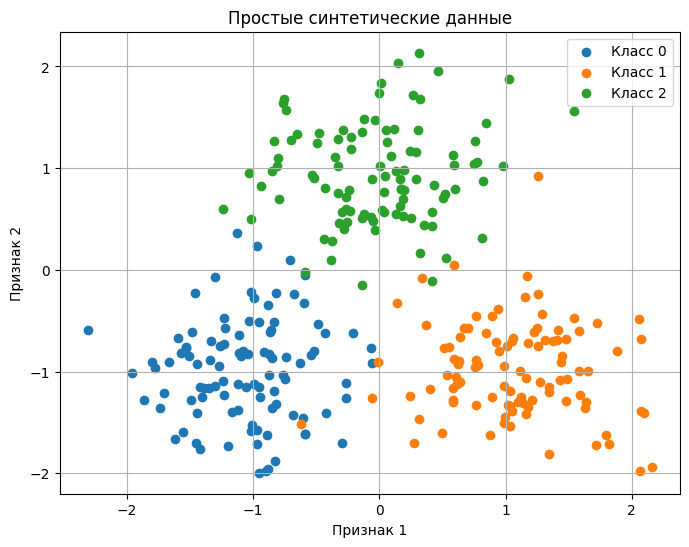

In [ ]:
def generate_simple_data():
    np.random.seed(42)
    num_samples = 100

    X0 = np.random.randn(num_samples, 2) * 0.5 + [-1, -1]
    y0 = np.zeros(num_samples)

    X1 = np.random.randn(num_samples, 2) * 0.5 + [1, -1]
    y1 = np.ones(num_samples)

    X2 = np.random.randn(num_samples, 2) * 0.5 + [0, 1]
    y2 = np.full(num_samples, 2)

    X = np.vstack([X0, X1, X2])
    y = np.hstack([y0, y1, y2])

    return X, y

X, y = generate_simple_data()

plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Класс 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Класс 1')
plt.scatter(X[y == 2, 0], X[y == 2, 1], label='Класс 2')
plt.legend()
plt.title('Простые синтетические данные')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.grid()
plt.show()


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

In [ ]:
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_bias, y_onehot, test_size=0.3, random_state=42, stratify=y_onehot)

In [ ]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, num_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose
        self.W = None

    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, Y, P):
        N = Y.shape[0]
        loss = -np.sum(Y * np.log(P + 1e-15)) / N
        return loss

    def fit(self, X, Y):
        N, d = X.shape
        M = Y.shape[1]
        self.W = np.zeros((d, M))

        for i in range(self.num_iterations):
            scores = X @ self.W
            P = self.softmax(scores)
            gradient = (X.T @ (P - Y)) / N
            self.W -= self.learning_rate * gradient
            if self.verbose and i % 100 == 0:
                loss = self.compute_loss(Y, P)
                print(f"Итерация {i}, Потери: {loss:.4f}")

    def predict_proba(self, X):
        scores = X @ self.W
        P = self.softmax(scores)
        return P

    def predict(self, X):
        P = self.predict_proba(X)
        return np.argmax(P, axis=1)


In [ ]:
model = SoftmaxRegression(learning_rate=0.1, num_iterations=1000, verbose=True)
model.fit(X_train, y_train)

Итерация 0, Потери: 1.0986
Итерация 100, Потери: 0.2127
Итерация 200, Потери: 0.1482
Итерация 300, Потери: 0.1234
Итерация 400, Потери: 0.1100
Итерация 500, Потери: 0.1014
Итерация 600, Потери: 0.0954
Итерация 700, Потери: 0.0910
Итерация 800, Потери: 0.0875
Итерация 900, Потери: 0.0847


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Точность: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

Точность: 0.9444
F1-Score: 0.9449


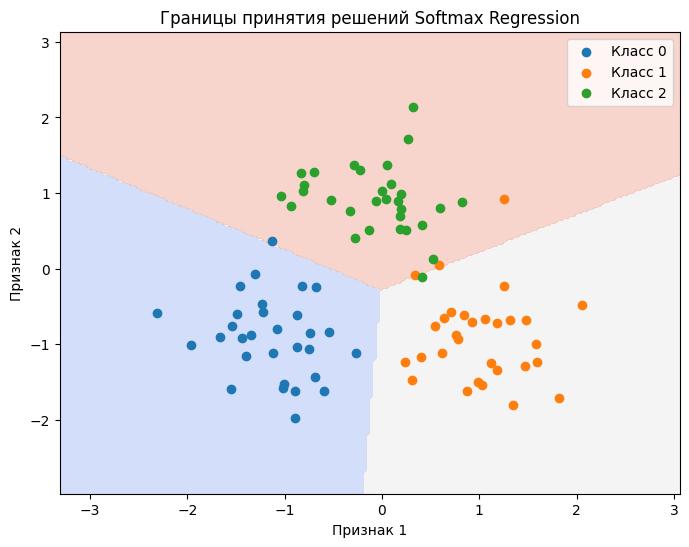

In [ ]:
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:,1].min() - 1, X[:,1].max() + 1
    y_min, y_max = X[:,2].min() - 1, X[:,2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()]
    probs = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, probs, alpha=0.3, levels=np.arange(-0.5, 3.5, 1), cmap=plt.cm.coolwarm)
    plt.scatter(X[y==0,1], X[y==0,2], label='Класс 0')
    plt.scatter(X[y==1,1], X[y==1,2], label='Класс 1')
    plt.scatter(X[y==2,1], X[y==2,2], label='Класс 2')
    plt.legend()
    plt.title(title)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.show()

plot_decision_boundaries(X_test, y_true, model, 'Границы принятия решений Softmax Regression')